# Benchmark - Generator -

## Import

In [1]:
import os
import math
import random
import pandas as pd
from glob import glob

import bonesis
from functools import reduce

import merrin.Loader as loader
from merrin.Parameters import FLUXOMIC_DATA, PROTEOMIC_DATA, CINETIC_DATA, DATA_TYPE_COLUMN

pd.options.mode.chained_assignment = None 

## Parameters

In [2]:
def create_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [3]:
benchmark_folder = './benchmark'
create_folder(benchmark_folder)

data_type = [
    [CINETIC_DATA, FLUXOMIC_DATA, PROTEOMIC_DATA],
    [CINETIC_DATA, PROTEOMIC_DATA],
    [PROTEOMIC_DATA],
    [CINETIC_DATA, FLUXOMIC_DATA]
]

metabolic_network_file = f'data/covert/metabolic_network.xml'
regulatory_network_file = f'data/covert/regulatory_network.sbml'
pkn_file = f'data/covert/interactions.txt'

experiment_datasets = {
    'covert': 'data/covert/result/pipeline_nbi/FlexFlux/out_times*.csv',
}

objective_function = 'Growth'
hide_reactions = False

In [4]:
# DEGRADATION RATE
seeds = range(0, 10)
degradations = range(0, 60, 10)

## Load files

In [5]:
mn = loader.load_sbml(metabolic_network_file)
inputs = sorted(mn.get_inputs())
pkn = loader.load_pkn(pkn_file, inputs)

<SBMLDocument>
data/covert/metabolic_network.xml
<Model Covert2011 "Covert2011">


# computing graph layout...


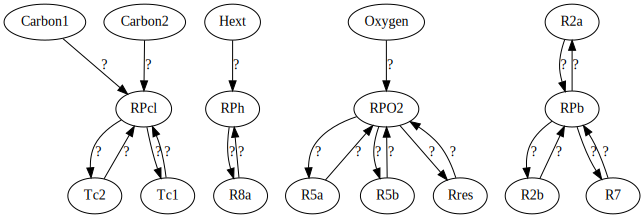

In [6]:
pkn

In [7]:
reactions  = mn.get_reactions()
external_reactions = set(r for r, _ in mn.get_input_reactions())
internal_reactions = reactions.difference(external_reactions)
inputs = mn.get_inputs()
outputs = mn.get_outputs()
regulators = set(pkn.nodes()).difference(reactions).difference(inputs).difference(outputs)

## Search Space

In [8]:
search_space = 0
bo = bonesis.BoNesis(bonesis.InfluenceGraph(pkn, allow_skipping_nodes=False))
for k in inputs:
    bo.custom(f'constant(\"{k}\", -1).')
space = bo.local_functions().as_dict('count')
search_space = reduce(int.__mul__, space.values())
search_space

Grounding...done in 0.0s


1797300787609600

## Data generation

In [9]:
def shift_external_metabolites(df):
    to_shift = list(inputs) + ['biomass']
    df[to_shift] = df[to_shift].shift(1)
    df.loc[0, to_shift] = df.loc[1, to_shift]

def read_simulation(csv_file: str) -> pd.DataFrame:
    df = pd.read_csv(csv_file, sep='\t')
    df['Time'] = [math.floor(i * 100) if i * 100 - math.floor(i * 100)
                  < 0.5 else math.ceil(i * 100) for i in df['Time']]
    df.set_index('Time', inplace=True)
    shift_external_metabolites(df)
    return df

def read_simulations(sims_path):
    simulations = {os.path.split(os.path.splitext(f)[0])[1]: read_simulation(f)
                   for i, f in enumerate(sorted(sims_path))}
    return simulations


In [10]:
def get_fluxomic(df):
    dg = df.copy()
    return dg[list(inputs.union(outputs).union(reactions)) + ['biomass']]

def get_cinetic(df):
    dg = df.copy()
    return dg[list(inputs.union(outputs).union(external_reactions)) + [objective_function, 'biomass']]

def get_proteomic(df):
    threshold = 10**-5
    dg = (df > threshold).astype(int)
    dg = dg.drop([objective_function, 'biomass', 'Biomass'], axis=1)
    return dg

def convert_data(simulations: dict):
    convert_inputs = {}
    for k, sim in simulations.items():
        fluxomic  = get_fluxomic(sim)
        cinetic   = get_cinetic(sim)
        proteomic = get_proteomic(sim)
        convert_inputs[k] = (fluxomic, cinetic, proteomic)
        
    return convert_inputs

In [11]:
def extract_phases(proteomic: pd.DataFrame):
    phases = []
    rows = list(proteomic.iterrows())
    current_row = (None, None)
    for i in range(len(rows)):
        t = i
        state = tuple(rows[i][1].to_list())
        if current_row[0] is None:
            current_row = (t, state)
        elif state != current_row[1]:
            phases.append((current_row[0], t-1))
            current_row = (t, state)
    phases.append((current_row[0], len(rows)-1))
    return phases

def compress_data(simulations: dict, degradation: float, seed:int = 0):
    random.seed(seed)
    assert(0 <= degradation and degradation < 1)
    compress_simulations = {}
    for k, sim in simulations.items():
        fluxomic, cinetic, proteomic = sim
        phases = extract_phases(proteomic)

        compress_sample = []
        for t1, t2 in phases:
            if t1 == t2:
                if random.random() >= degradation:
                    compress_sample.append(t1)
            else:
                n = t2 - t1 + 1
                prob_0 = degradation**n
                prob_1 = degradation**(n-1) * (1 - degradation)
                prob_less_than_2 = prob_0 + prob_1
                rand_prob = random.random()
                if prob_less_than_2 <= rand_prob:
                    compress_sample.extend(list(random.sample(range(t1, t2 + 1), 2)))
                elif prob_1 <= rand_prob:
                    compress_sample.extend(list(random.sample(range(t1, t2 + 1), 1)))
        compress_sample.sort()
        if compress_sample[0] != 0:
            compress_sample = [0] + compress_sample
        
        c_fluxomic = fluxomic.iloc[compress_sample]
        c_cinetic = cinetic.iloc[compress_sample]
        c_proteomic = proteomic.iloc[compress_sample]

        compress_simulations[k] = (c_fluxomic, c_cinetic, c_proteomic)

    return compress_simulations


In [12]:
def fluxomic_noise(fluxomic: pd.DataFrame, degradation: float, seed:int = 0):
    random.seed(seed)
    n_fluxomic = fluxomic.applymap(lambda x: x * (1 + random.uniform(-degradation, degradation)))
    return n_fluxomic

def cinetic_noise(cinetic: pd.DataFrame, degradation: float, seed:int = 0):
    random.seed(seed)
    n_cinetic = cinetic.applymap(lambda x: x * (1 + random.uniform(-degradation, degradation)))
    return n_cinetic

def proteomic_noise(proteomic: pd.DataFrame, degradation: float, seed:int = 0):
    random.seed(seed)
    n_proteomic = proteomic.copy()
    reactions_without_obj = reactions.union(regulators)
    reactions_without_obj.remove(objective_function)
    reactions_without_obj = list(reactions_without_obj)
    n_proteomic[reactions_without_obj] = n_proteomic[reactions_without_obj].applymap(lambda x: None if random.random() < degradation else x)
    return n_proteomic

def add_noise(simulations: dict, degradation:float, seed:int = 0):
    assert(0 <= degradation and degradation < 1)
    random.seed(seed)

    f_seed = int(random.random() * 100)
    c_seed = int(random.random() * 100)
    p_seed = int(random.random() * 100)

    noisy_simulations = {}
    for k, sim in simulations.items():
        fluxomic, cinetic, proteomic = sim
        fluxomic = fluxomic_noise(fluxomic, degradation, f_seed)
        cinetic = cinetic_noise(cinetic, degradation, c_seed)
        proteomic = proteomic_noise(proteomic, degradation, p_seed)

        noisy_simulations[k] = (fluxomic, cinetic, proteomic)

    return noisy_simulations

In [13]:
def drop_observations(simulations: dict, degradation:float, seed:int = 0):
    assert(0 <= degradation and degradation < 1)
    random.seed(seed)

    drop_simulations = {}
    for k, sim in simulations.items():
        fluxomic, cinetic, proteomic = sim

        sample = [0, 301] + random.sample(sorted(fluxomic.index[1:-1]), int((len(fluxomic.index) - 2) * (1 - degradation)))
        sample.sort()

        d_fluxomic = fluxomic.loc[sample]
        d_cinetic = cinetic.loc[sample]
        d_proteomic = proteomic.loc[sample]

        drop_simulations[k] = (d_fluxomic, d_cinetic, d_proteomic)

    return drop_simulations

In [14]:
def build_instance(simulations, isfluxomic:bool, iscinetic:bool, isproteomic:bool):
    instances = {}
    for k, sim in simulations.items():
        fluxomic, cinetic, proteomic = sim

        cinetic_col = list(inputs.union(outputs).union(external_reactions)) + [objective_function, 'biomass']
        fluxomic_col = list(inputs.union(outputs).union(reactions)) + ['biomass']

        instance = proteomic.copy()
        if not isproteomic:
            instance = instance.drop(list(regulators), axis=1)
        if isfluxomic:
            instance[fluxomic_col] = fluxomic[fluxomic_col]
        if iscinetic or isfluxomic:
            instance[cinetic_col] = cinetic[cinetic_col]


        tags = []
        if isfluxomic: tags.append(FLUXOMIC_DATA)
        if iscinetic: tags.append(CINETIC_DATA)
        if isproteomic: tags.append(PROTEOMIC_DATA)
        instance[DATA_TYPE_COLUMN] = ','.join(tags)

        instances[k] = instance

    return instances

## Benchmark generation

In [15]:
ref_simulations = read_simulations(glob(experiment_datasets['covert']))
ref_convert_simulations = convert_data(ref_simulations)

for seed in seeds:
    for degradation in degradations:
        degradation /= 100
        compress_simulations = compress_data(ref_convert_simulations, degradation, seed)
        noise_simulations = add_noise(compress_simulations, degradation, seed)
        for tags in data_type:
            instance = build_instance(
                noise_simulations,
                FLUXOMIC_DATA in tags,
                CINETIC_DATA in tags,
                PROTEOMIC_DATA in tags
            )
            tags.sort()
            tags_str = ''.join([t[0] for t in tags])
            export_path = benchmark_folder + f'/instances/datatype-{tags_str}/degradation-{int(degradation*100)}%/seed-{seed}/'
            create_folder(export_path)

            for k, sim in instance.items():
                sim.to_csv(export_path + k + '.csv')